In [1]:
# Load model directly
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("llava-hf/llava-1.5-7b-hf")
model = AutoModelForImageTextToText.from_pretrained("llava-hf/llava-1.5-7b-hf")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [2]:
import requests
from PIL import Image
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration

# Load the model and processor
model_id = "llava-hf/llava-1.5-7b-hf"
model = LlavaForConditionalGeneration.from_pretrained(
    model_id, 
    torch_dtype=torch.float16, 
    low_cpu_mem_usage=True, 
).to(0)

processor = AutoProcessor.from_pretrained(model_id)

# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What are these?"},
            {"type": "image"},
        ],
    },
]
prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)

# Load and preprocess the image
image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(images=raw_image, text=prompt, return_tensors='pt').to(0, torch.float16)

# Forward pass to get logits
with torch.no_grad():
    output = model(**inputs)
    logits = output.logits  # Shape: (batch_size, sequence_length, vocab_size)

# Generate the output tokens using model.generate
generated_ids = model.generate(**inputs, max_new_tokens=1, do_sample=False)

# Decode the generated tokens to get the actual output
output_text = processor.decode(generated_ids[0][2:], skip_special_tokens=True)
print("Model Output:", output_text)

# Extract logits for the generated tokens
# Here we take logits only for the generated tokens
token_logits = []
for i, token_id in enumerate(generated_ids[0]):
    token_logits.append(logits[0, i, token_id].item())

# Print logits for each generated token
print("\nLogits for each token in the output:")
for token, logit in zip(processor.tokenizer.convert_ids_to_tokens(generated_ids[0]), token_logits):
    print(f"Token: {token}, Logit: {logit}")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.
Expanding inputs for image tokens in LLaVa should be done in processing. Please add `patch_size` and `vision_feature_select_strategy` to the model's processing config or set directly with `processor.patch_size = {{patch_size}}` and processor.vision_feature_select_strategy = {{vision_feature_select_strategy}}`. Using processors without these attributes in the config is deprecated and will throw an error in v4.47.


Model Output: ER:  
What are these? ASSISTANT: These

Logits for each token in the output:
Token: <s>, Logit: 0.70751953125
Token: ▁US, Logit: -0.1290283203125
Token: ER, Logit: 4.140625
Token: :, Logit: 2.908203125
Token: ▁, Logit: 4.09375
Token: <image>, Logit: 0.2261962890625
Token: ▁, Logit: 7.23046875
Token: <0x0A>, Logit: 9.734375
Token: What, Logit: 5.03515625
Token: ▁are, Logit: 6.69921875
Token: ▁these, Logit: 6.8828125
Token: ?, Logit: 4.53125
Token: ▁A, Logit: 6.92578125
Token: SS, Logit: 0.43212890625
Token: IST, Logit: -0.95751953125
Token: ANT, Logit: -1.0126953125
Token: :, Logit: 8.71875
Token: ▁These, Logit: 4.5859375


In [9]:
import numpy as np
import pandas as pd
import json
from PIL import Image
import requests
import torch
from transformers import AutoProcessor
import os
import glob
from tqdm import trange
import torch.nn.functional as F

In [10]:
from datasets import load_dataset

ds = load_dataset("vikhyatk/st-vqa")


README.md:   0%|          | 0.00/429 [00:00<?, ?B/s]

train-00000-of-00006.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00001-of-00006.parquet:   0%|          | 0.00/503M [00:00<?, ?B/s]

train-00002-of-00006.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00003-of-00006.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00004-of-00006.parquet:   0%|          | 0.00/505M [00:00<?, ?B/s]

train-00005-of-00006.parquet:   0%|          | 0.00/501M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18921 [00:00<?, ? examples/s]

In [11]:
extra_config = {'max_new_tokens':100}

In [12]:
ds['train']

Dataset({
    features: ['image', 'qas'],
    num_rows: 18921
})

In [13]:
example = ds['train'][0]
example

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x400>,
 'qas': [{'question': 'What is the book authors first name?',
   'answers': ['Susan']},
  {'question': 'what is the book authors last name?',
   'answers': ['Blackmore']}]}

In [22]:
correct = 0
total = 0
false_case =  []

for i in trange(50):

    example = ds['train'][i]
    image = example['image']
    questions_li = example['qas']
    qa_pair = [(q['question'], q['answers']) for q in questions_li]    

    for q, a_li in qa_pair:
        messages = [

                {"role": "user", "content": [
                    {"type": "image"},
                    {"type": "text", "text": "Only reply with the answer, do not include explanation. " + q}
                ]}
            ]
        input_text = processor.apply_chat_template(messages, add_generation_prompt=True)
        inputs = processor(images=image, text=input_text, return_tensors='pt').to(0, torch.float16)

        generated_ids = model.generate(**inputs, max_new_tokens=10, do_sample=False)
        output_text = processor.decode(generated_ids[0][2:], skip_special_tokens=True)
        print("Model Output:", output_text)
        
        for a in a_li:
            total += 1
            print("The answer is: ")
            print(a)
            if a.lower() in output_text.lower():
                print("Matched")
                correct += 1
            else:
                print("Not Matched")
                false_case.append((q, output_text, example))

                # break
print(correct/total)
        

  0%|                                                                                                                                                  | 0/50 [00:00<?, ?it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the book authors first name? ASSISTANT: Susan
The answer is: 
Susan
Matched


  2%|██▊                                                                                                                                       | 1/50 [00:00<00:23,  2.10it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. what is the book authors last name? ASSISTANT: Blum
The answer is: 
Blackmore
Not Matched


  4%|█████▌                                                                                                                                    | 2/50 [00:00<00:15,  3.06it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Who's name is on the cake? ASSISTANT: Chris
The answer is: 
Chris
Matched


  6%|████████▎                                                                                                                                 | 3/50 [00:00<00:14,  3.21it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does the writing on the bottom of the picture read? ASSISTANT: Big kites
The answer is: 
Big Kites
Matched


  8%|███████████                                                                                                                               | 4/50 [00:01<00:13,  3.45it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What company is advertised on the red sign? ASSISTANT: Hh
The answer is: 
Helly Hansen
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. Where is the Pacific Hwy Exit going to? ASSISTANT: North Sydney
The answer is: 
North Sydney
Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. Where is the Falcon Street exit going to? ASSISTANT: North Sydney
The answer is: 
Crows Nest
Not Matched


 10%|█████████████▊                                                                                                                            | 5/50 [00:02<00:20,  2.17it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the Mosman Manly exit going to? ASSISTANT: Mosman
The answer is: 
Chatswood Epping
Not Matched


 12%|████████████████▌                                                                                                                         | 6/50 [00:02<00:16,  2.60it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does it say on the red sign? ASSISTANT: Stop
The answer is: 
STOP
Matched


 14%|███████████████████▎                                                                                                                      | 7/50 [00:02<00:15,  2.73it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does the logo on the upper left say? ASSISTANT: Can't read
The answer is: 
MyProfe
Not Matched


 16%|██████████████████████                                                                                                                    | 8/50 [00:02<00:14,  2.92it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What airline is this? ASSISTANT: Air france
The answer is: 
Airfrance
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What does Espressa sell? ASSISTANT: Pizza
The answer is: 
pizza
Matched


 18%|████████████████████████▊                                                                                                                 | 9/50 [00:03<00:15,  2.59it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the cost for delivery of Espressa Pizza? ASSISTANT: Free
The answer is: 
FREE DELIVERY
Not Matched


 20%|███████████████████████████▍                                                                                                             | 10/50 [00:03<00:14,  2.77it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does the sign on the right say? ASSISTANT: Collaborate
The answer is: 
Collabora
Matched


 22%|██████████████████████████████▏                                                                                                          | 11/50 [00:03<00:12,  3.04it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Who is the sponsor of this tournament ASSISTANT: Blackrock
The answer is: 
blackrock
Matched


 24%|████████████████████████████████▉                                                                                                        | 12/50 [00:04<00:14,  2.66it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is written on the top left of the white board? ASSISTANT: Book and stationery event of the year
The answer is: 
Book and Stationary Event of the Year!
Not Matched
The answer is: 
BOOK AND STATIONERY EVENT OF THE YEAR
Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What is the number of mini jet? ASSISTANT: N522FF
The answer is: 
N5226F
Not Matched


 26%|███████████████████████████████████▌                                                                                                     | 13/50 [00:05<00:16,  2.22it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Who is holding the mini jet? ASSISTANT: No one
The answer is: 
U.S. AIR FORCE
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What piece of fruit is the man holding? ASSISTANT: Banana
The answer is: 
banana
Matched


 28%|██████████████████████████████████████▎                                                                                                  | 14/50 [00:05<00:17,  2.11it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. How many men are in the picture? ASSISTANT: 2
The answer is: 
two
Not Matched


 30%|█████████████████████████████████████████                                                                                                | 15/50 [00:05<00:15,  2.27it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What year does it say on the bottom right? ASSISTANT: 2013
The answer is: 
2013
Matched


 32%|███████████████████████████████████████████▊                                                                                             | 16/50 [00:06<00:13,  2.57it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the first word on the tag? ASSISTANT: Mts
The answer is: 
Goldfiel
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What is the brand name of this product? ASSISTANT: Pride
The answer is: 
Pride.
Not Matched


 34%|██████████████████████████████████████████████▌                                                                                          | 17/50 [00:06<00:14,  2.34it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the size of the items according to the label? ASSISTANT: Small
The answer is: 
Jumbo.
Not Matched


 36%|█████████████████████████████████████████████████▎                                                                                       | 18/50 [00:06<00:12,  2.58it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the name of the cooking device? ASSISTANT: Crockpot
The answer is: 
CROCK-POT
Not Matched


 38%|████████████████████████████████████████████████████                                                                                     | 19/50 [00:07<00:10,  2.87it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the yellow number? ASSISTANT: 1
The answer is: 
7
Not Matched


 40%|██████████████████████████████████████████████████████▊                                                                                  | 20/50 [00:07<00:09,  3.01it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. what event is this? ASSISTANT: Birthday
The answer is: 
birthday
Matched


 42%|█████████████████████████████████████████████████████████▌                                                                               | 21/50 [00:07<00:08,  3.35it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. what color is mentioned in the text ASSISTANT: Black
The answer is: 
black
Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What is the bus number above the windshield? ASSISTANT: 6067
The answer is: 
160
Not Matched


 44%|████████████████████████████████████████████████████████████▎                                                                            | 22/50 [00:08<00:11,  2.46it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Where is the bus heading? ASSISTANT: Monclava
The answer is: 
MONCLOA ARAVACA
Not Matched


 46%|███████████████████████████████████████████████████████████████                                                                          | 23/50 [00:08<00:10,  2.53it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the motorcycle's license plate? ASSISTANT: 1448
The answer is: 
NXU4489
Not Matched
The answer is: 
NXU 4489
Not Matched


 48%|█████████████████████████████████████████████████████████████████▊                                                                       | 24/50 [00:09<00:09,  2.83it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does the red sign read? ASSISTANT: Danger
The answer is: 
Stop
Not Matched


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 25/50 [00:09<00:08,  2.98it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the name of the bar? ASSISTANT: The Temple Bar
The answer is: 
The Temple Bar
Matched


 52%|███████████████████████████████████████████████████████████████████████▏                                                                 | 26/50 [00:09<00:07,  3.32it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Which month is in the caption? ASSISTANT: August
The answer is: 
aug
Matched


 54%|█████████████████████████████████████████████████████████████████████████▉                                                               | 27/50 [00:09<00:06,  3.55it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the name on the tail wing? ASSISTANT: American
The answer is: 
Virgin
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What does the bottom of the snowboard say? ASSISTANT: Custom
The answer is: 
Custom
Matched


 56%|████████████████████████████████████████████████████████████████████████████▋                                                            | 28/50 [00:10<00:07,  2.94it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What brand name is listed on the sign to the right? ASSISTANT: Burton
The answer is: 
Burton
Matched


 58%|███████████████████████████████████████████████████████████████████████████████▍                                                         | 29/50 [00:10<00:07,  2.63it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does the copyright on this image say? ASSISTANT: Samuel's 2011
The answer is: 
Bridget Samuels 2011
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What type of car is this? ASSISTANT: Taxi
The answer is: 
Taxi
Matched


 60%|██████████████████████████████████████████████████████████████████████████████████▏                                                      | 30/50 [00:11<00:08,  2.32it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is written on the front window? ASSISTANT: Not in service
The answer is: 
Not in Service
Matched


 62%|████████████████████████████████████████████████████████████████████████████████████▉                                                    | 31/50 [00:11<00:07,  2.43it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What year is the copyright? ASSISTANT: 2009
The answer is: 
2009
Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What is the name of the AVE in the picture? ASSISTANT: 1st
The answer is: 
1st
Matched
The answer is: 
1st AVE
Not Matched


 64%|███████████████████████████████████████████████████████████████████████████████████████▋                                                 | 32/50 [00:12<00:08,  2.21it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the name of the ST in the picture? ASSISTANT: Madison
The answer is: 
Madison
Matched
The answer is: 
Madison ST
Not Matched


 66%|██████████████████████████████████████████████████████████████████████████████████████████▍                                              | 33/50 [00:12<00:06,  2.47it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Who took this photo? ASSISTANT: Photographer
The answer is: 
matt dwen
Not Matched


 68%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 34/50 [00:12<00:05,  2.70it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What hair product brand is sponsoring this match? ASSISTANT: Garnier
The answer is: 
Garnier
Matched


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 35/50 [00:13<00:05,  2.95it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is written on the display sign? ASSISTANT: Office equipment
The answer is: 
Office Equipment
Matched


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 36/50 [00:13<00:04,  3.14it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the text on the traffic sign? ASSISTANT: Yield
The answer is: 
SCHOOL BUS STOP AHEAD
Not Matched


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 37/50 [00:13<00:04,  3.21it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. what is the name of bike? ASSISTANT: Rapidol
The answer is: 
repsol
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What letter is presented on the black flag? ASSISTANT: M
The answer is: 
M
Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. There are two numbers presented on the flag. What are they? ASSISTANT: 10
The answer is: 
09
Not Matched


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 38/50 [00:14<00:06,  1.89it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is presented on the flag? ASSISTANT: The flag has a picture of a handbag on
The answer is: 
m '09
Not Matched


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 39/50 [00:14<00:05,  2.13it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the number on the street curb? ASSISTANT: 211
The answer is: 
311
Not Matched


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 40/50 [00:15<00:04,  2.47it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is written on the side of the switch? ASSISTANT: CK
The answer is: 
C & K
Not Matched
The answer is: 
C & K C.R
Not Matched


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 41/50 [00:15<00:03,  2.66it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What kind of of donut is this? ASSISTANT: Pumpkin
The answer is: 
Pumpkin chocolate chip donuts
Not Matched
The answer is: 
PUMPKIN  CHOCOLATE CHIP
Not Matched


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 42/50 [00:15<00:02,  2.94it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does the top left button of this remote control read? ASSISTANT: Cable
The answer is: 
Code Search
Not Matched


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 43/50 [00:16<00:02,  2.97it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What does the sign say? ASSISTANT: Stop men at work
The answer is: 
Stop Men At Work
Matched


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 44/50 [00:16<00:01,  3.20it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the brand name visible on the side wall? ASSISTANT: Olympus
The answer is: 
OLYMPUS
Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What is the number code written on the train? ASSISTANT: 558289
The answer is: 
528818
Not Matched


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 45/50 [00:17<00:02,  2.34it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What is the name of the company written on the train ASSISTANT: Gvr
The answer is: 
Golden West Service
Not Matched


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 46/50 [00:17<00:01,  2.66it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What initials are on the top of the machine? ASSISTANT: LG
The answer is: 
LG
Matched


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 47/50 [00:17<00:01,  2.60it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Who does the Wholesale Nursey sell to? ASSISTANT: Wholesale Nursery
The answer is: 
PUBLIC
Not Matched


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 48/50 [00:18<00:00,  2.85it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. How many skateboards can you see? ASSISTANT: 1
The answer is: 
3
Not Matched
The answer is: 
4
Not Matched
Model Output: ER:  
Only reply with the answer, do not include explanation. What does the red sign board show? ASSISTANT: Stop
The answer is: 
STOP
Matched


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 49/50 [00:18<00:00,  2.42it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. Which Avenue is displayed near the stop board? ASSISTANT: 1st Avenue
The answer is: 
Avenue 55
Not Matched
The answer is: 
55
Not Matched


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.65it/s]

Model Output: ER:  
Only reply with the answer, do not include explanation. What avenue is shown? ASSISTANT: 5 av
The answer is: 
5 Av
Matched
0.410958904109589


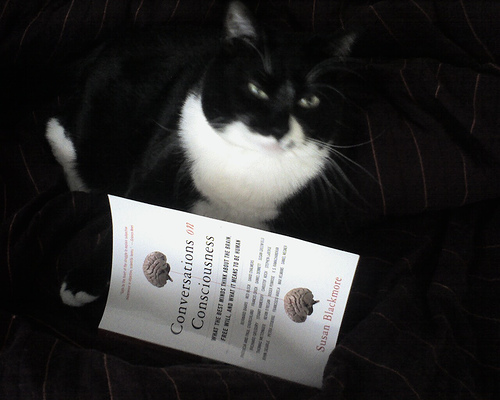

In [23]:
false_case[0][2]['image']

In [29]:
false_case[0][2]['image'].save("downloaded_image.jpg") 

In [27]:
false_case[0][2]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x400>,
 'qas': [{'question': 'What is the book authors first name?',
   'answers': ['Susan']},
  {'question': 'what is the book authors last name?',
   'answers': ['Blackmore']}]}

In [25]:
for a in a_li:
    if a.lower() in extracted_content.lower():
        print(a)
        # break

NameError: name 'extracted_content' is not defined